## **To recreate study results please load package versions found in main_requirements.txt**

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mp
import math
import seaborn as sns
import os

# less common imports
from sklearn import preprocessing
from scipy.stats import f
from sklearn.cluster import AgglomerativeClustering
import matplotlib.cm as cm

# %config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

sc.settings.verbosity = 0
sc.logging.print_header()
sns.set_context("paper")

/home/serhiy/Desktop/code/2_single_cell/dulac_kaplan2023_dev_regulation_snRNAseq_scATACseq_mouse_hbc04623/data/hotspot_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.2 anndata==0.8.0 umap==0.5.3 numpy==1.22.3 scipy==1.8.1 pandas==1.5.3 scikit-learn==1.2.1 statsmodels==0.13.5 pynndescent==0.5.8


In [2]:
# import local module containing misc code, helps keep notebooks clean from commonly used functions
import new_misc_code as nmc

In [15]:
#test = nmc.load_obj("data/dev_deg_v7/ax.pkl")

## **Load anndata and GAM fit stage gene trends**

In [3]:
# read in anndata for obs
# don't read to save memory
# adata = sc.read_h5ad("data/2023-05-16_input/seurat.excitatory_select.h5ad")
# adata = sc.read_h5ad("data/2023-05-16_input/seurat.inhibitory_select.h5ad")

In [3]:
n_splines = 12
n_grid_pts = 100
# good_fits = nmc.load_obj(f"data/dev_deg_v7/AGE_gam_fits_12_grid{n_grid_pts}.pkl")
good_fits = nmc.load_obj("data/dev_deg_v8/AGE_gam_fits_12_grid100.filtered100.pkl")
gam_fits = good_fits
logTMMs = nmc.load_obj(f"data/dev_deg_v8/logTMMs.filtered100.pkl")

In [28]:
# subset files according to the overlap with the mutant experiment
#len(good_fits['e-A2'])
pd_mutant_overlap = pd.read_csv("tables/T3.cell_types_genes_intersect.csv")
mutant_overlap = pd_mutant_overlap['cell_type']
cell_types_all = list(logTMMs.keys())
cell_types_remove = list(set(cell_types_all) - set(mutant_overlap))

for k in cell_types_remove:
    gam_fits.pop(k, None)
    logTMMs.pop(k, None)

nmc.save_obj(gam_fits, f"data/dev_deg_v9/AGE_gam_fits_12_grid{n_grid_pts}.filtered100.pkl")
nmc.save_obj(logTMMs, f"data/dev_deg_v9/logTMMs.filtered100.pkl")

In [3]:
gam_fits1 = nmc.load_obj("data/dev_deg_v9/AGE_gam_fits.overlap.pkl")
logTMMs = nmc.load_obj("data/dev_deg_v9/logTMMs.overlap.pkl")

In [9]:
for cell_type in gam_fits1:
    gam_fits1[cell_type].to_csv(f"data/dev_deg_v9/logTMMs/{cell_type}.csv")

In [52]:
gam_fits1 = {}
logTMMs1 = {}
for cell_type in gam_fits:
    # cell_type = 'e-A1'
    genes_to_select = list(pd_mutant_overlap[pd_mutant_overlap.cell_type.isin([cell_type])].gene_name)
    gam_fits1[cell_type] = gam_fits[cell_type].loc[genes_to_select]
    logTMMs1[cell_type] = logTMMs[cell_type].loc[genes_to_select]
nmc.save_obj(gam_fits1, f"data/dev_deg_v9/AGE_gam_fits.overlap.pkl")
nmc.save_obj(logTMMs, f"data/dev_deg_v9/logTMMs.overlap.pkl")

In [53]:
logTMMs = logTMMs1
gam_fits = gam_fits1
cell_type = 'e-A1'
logTMMs[cell_type]

,e.A1..e16f,e.A1..e16m_apr23,e.A1..e18f,e.A1..e18f_may22,e.A1..e18m_may22,e.A1..p0f2,e.A1..p0m_april,e.A1..p10f,e.A1..p10f_mar23,e.A1..p10m,...,e.A1..p28m,e.A1..p28m_may22,e.A1..p4f,e.A1..p4f_oct,e.A1..p4m,e.A1..p4m_mar23,e.A1..p65f_apr23,e.A1..p65f_april,e.A1..p65m_april,e.A1..p65m_aug
Adgrb3,9.882444,9.774940,9.857745,9.576646,9.500074,9.311345,9.112342,9.719420,9.743559,9.856033,...,9.837343,9.923928,9.447011,9.945052,9.649321,9.731602,9.773790,9.841465,9.834277,9.884151
Cox5b,6.963596,7.159172,7.804601,8.131533,8.727111,7.099672,7.643916,6.833675,7.818104,6.861878,...,6.151714,8.352357,6.940050,6.529568,7.300598,7.427805,6.034276,6.756200,6.378869,7.272408
Rpl37a,7.412319,7.291996,7.818956,8.469234,8.897321,6.516683,6.823427,7.112990,7.421515,6.923880,...,6.608833,8.677726,7.905770,6.267073,8.135204,8.163159,6.818986,7.163696,8.224311,7.506627
Tuba4a,3.410986,3.865293,4.622839,5.204113,5.809678,3.410986,6.354562,6.380826,7.170853,6.700245,...,6.386981,7.885606,7.147206,5.092282,6.785187,6.406849,5.718287,6.282565,6.170364,6.639413
Resp18,7.867981,8.521713,8.656335,9.105655,9.434789,8.840292,8.884589,9.122037,9.675972,9.227329,...,9.078600,10.271694,8.964612,8.273888,9.293361,9.140238,9.326506,9.609897,9.665769,9.715591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gdi1,7.442949,7.856133,7.429384,7.952081,8.362628,7.494840,7.868765,7.081698,7.254098,7.484823,...,7.209760,8.080575,8.085892,7.362945,7.595743,8.155478,7.176930,6.848420,7.019100,7.112021
Arxes2,7.657459,7.587313,6.639853,8.418572,8.576299,3.410986,6.541240,6.683324,7.121718,7.051946,...,6.118700,7.974783,7.293222,6.402465,7.738696,7.816130,6.286299,6.841528,7.806713,7.392957
Bex2,8.155085,8.464924,8.241861,8.856291,9.451829,7.718682,8.567470,8.260581,8.542268,8.031669,...,7.216708,9.122995,8.539502,7.639725,8.694914,8.907021,6.942387,7.723025,7.636040,7.793110
Ubqln2,7.212269,7.726524,6.995913,7.978790,8.174042,6.912521,6.012943,6.841925,7.137042,6.995499,...,6.214639,7.319871,7.984473,6.952933,7.533243,7.453336,6.160704,6.633567,5.010086,6.732714


## **Hierarchical Trend Clustering**

In [54]:
# concat all trajectories into one dataframe 
all_goods_df = pd.concat(list( good_fits.values()), keys=list(good_fits.keys()))
all_goods_df.index.names = ['cell_type', 'gene']

In [55]:
all_goods_df.head()

0         1         2         3         4         5   \
cell_type gene                                                                  
e-A1      Xkr4     9.600451  9.583913  9.568115  9.553085  9.538851  9.525441   
          Pcmtd1   7.209317  7.190375  7.173760  7.159570  7.147903  7.138857   
          Gm26901  5.600264  5.571202  5.544242  5.519294  5.496265  5.475064   
          Sntg1    8.581948  8.598201  8.615467  8.633698  8.652849  8.672872   
          Mcmdc2   4.424097  4.445594  4.467654  4.490134  4.512892  4.535787   

                         6         7         8         9   ...        90  \
cell_type gene                                             ...             
e-A1      Xkr4     9.512885  9.501209  9.490443  9.480615  ...  9.451363   
          Pcmtd1   7.132531  7.129022  7.128428  7.130849  ...  7.584321   
          Gm26901  5.455599  5.437777  5.421508  5.406700  ...  5.304675   
          Sntg1    8.693721  8.715348  8.737707  8.760750  ...  9.218253   
          Mcmdc2   4.558676  4.581417  4.603870  4.625892  ...  5.337399   

                         91        92        93        94        95        96  \
cell_type gene                                                                  
e-A1      Xkr4     9.452386  9.453418  9.454457  9.455504  9.456557  9.457616   
          Pcmtd1   7.581327  7.578337  7.575351  7.572368  7.569389  7.566411   
          Gm26901  5.310744  5.316829  5.322926  5.329036  5.335157  5.341287   
          Sntg1    9.221815  9.225430  9.229095  9.232804  9.236552  9.240332   
          Mcmdc2   5.339175  5.340947  5.342715  5.344481  5.346244  5.348005   

                         97        98        99  
cell_type gene                                   
e-A1      Xkr4     9.458679  9.459745  9.460815  
          Pcmtd1   7.563436  7.560463  7.557491  
          Gm26901  5.347424  5.353568  5.359716  
          Sntg1    9.244141  9.247972  9.251820  
          Mcmdc2   5.349764  5.351521  5.353277  

[5 rows x 100 columns]

In [56]:
# image formatting
cmap = sns.color_palette( "ch:start=.2,rot=-.3", n_colors=1_000)
sns.set_context( context='paper')
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'lightgrey'})

In [57]:
key_itr = "i-B1"
#key_itr = "e-A1"
sig_df = logTMMs[key_itr]
ax_age = [s.split("..")[1].split("_")[0] for s in sig_df.columns]
#ax_age
ai_age = []
# only for samples which are part of pseudobulk
sample_age = {}
for age in ax_age:
    i_age = 0
    if age[0] == "e":
        i_age = int(age[1:3])
    elif age[0:2] == "p0":
        i_age = 20
    elif age[0:2] == "p4":
        i_age = 24
    else:
        i_age = int(age[1:3]) + 20
    ai_age.append(i_age)
    sample_age[age] = i_age
stage_order = list(np.unique(ai_age))
print(stage_order)

[16, 18, 20, 24, 30, 38, 48, 85]


In [12]:
# using seaborn clustermap, which uses scipy hierarchical clustering
# this will take a while to run
# may need all memory ~ 20G
# took 200G for all cell types
# Sept 28 22:53 start 
# ax = sns.clustermap(all_goods_df, metric='euclidean', method='ward', 
#                    col_cluster=False, row_cluster=True, cmap=cmap, 
#                    figsize=(15,15), standard_scale=0)
#nmc.save_obj(ax, "data/dev_deg_v8/ax.pkl")
ax = nmc.load_obj("data/dev_deg_v8/ax.pkl")
# legend
ax.cax.set_visible(True)
# stage_order =  [0, 1, 2, 3, 4, 5, 6, 7]
xlabels = ["e16", "e18", "p0", "p4", "p10", "p18", "p28", "p65"]
num_stages = len(stage_order)
ticks = np.linspace(0, all_goods_df.shape[1], num_stages)
ax.ax_heatmap.set_xticks(ticks)
ax.ax_heatmap.set_xticklabels(stage_order, rotation=90);
ax.ax_row_dendrogram.set_visible(True)
plt.setp( ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
ax.ax_heatmap.set_title( "Trend Fit Clustering")

ModuleNotFoundError: No module named 'matplotlib.axes._subplots'

In [11]:
all_goods_df

0         1         2         3         4   \
cell_type gene                                                           
i-B1      Xkr4        9.767914  9.751990  9.736122  9.720320  9.704596   
          Gm1992      5.630184  5.641261  5.652306  5.663366  5.674488   
          Lypla1      4.288638  4.305782  4.323423  4.341630  4.360474   
          Rgs20       5.145128  5.180054  5.215361  5.251109  5.287360   
          Oprk1       3.752248  3.823546  3.895306  3.967517  4.040169   
...                        ...       ...       ...       ...       ...   
i-V1      mt-Nd3      6.227332  6.417678  6.601117  6.776957  6.944501   
          mt-Nd4      7.767067  7.862882  7.955278  8.043858  8.128220   
          mt-Nd5      6.289676  6.402655  6.513736  6.622487  6.728478   
          mt-Cytb     7.991726  8.053848  8.113576  8.170710  8.225050   
          AC149090.1  9.784026  9.761926  9.739787  9.717722  9.695847   

                            5         6         7         8         9   ...  \
cell_type gene                                                          ...   
i-B1      Xkr4        9.688961  9.673427  9.658004  9.642704  9.627539  ...   
          Gm1992      5.685721  5.697112  5.708709  5.720559  5.732711  ...   
          Lypla1      4.380023  4.400346  4.421512  4.443591  4.466651  ...   
          Rgs20       5.324172  5.361608  5.399728  5.438592  5.478261  ...   
          Oprk1       4.113252  4.186755  4.260667  4.334979  4.409680  ...   
...                        ...       ...       ...       ...       ...  ...   
i-V1      mt-Nd3      7.103055  7.251926  7.390417  7.517836  7.633487  ...   
          mt-Nd4      8.207968  8.282701  8.352021  8.415529  8.472827  ...   
          mt-Nd5      6.831278  6.930454  7.025577  7.116216  7.201939  ...   
          mt-Cytb     8.276397  8.324550  8.369310  8.410477  8.447852  ...   
          AC149090.1  9.674277  9.653125  9.632506  9.612535  9.593327  ...   

                            90        91        92        93        94  \
cell_type gene                                                           
i-B1      Xkr4        9.513503  9.509495  9.505437  9.501334  9.497192   
          Gm1992      6.095930  6.108943  6.122151  6.135534  6.149073   
          Lypla1      5.801185  5.809093  5.816989  5.824874  5.832748   
          Rgs20       6.234677  6.236051  6.237509  6.239041  6.240641   
          Oprk1       5.707762  5.713808  5.719974  5.726248  5.732618   
...                        ...       ...       ...       ...       ...   
i-V1      mt-Nd3      7.640066  7.646962  7.654014  7.661206  7.668523   
          mt-Nd4      8.211285  8.208962  8.206717  8.204542  8.202430   
          mt-Nd5      7.335271  7.339177  7.343269  7.347530  7.351941   
          mt-Cytb     8.457925  8.456895  8.455916  8.454984  8.454093   
          AC149090.1  9.742536  9.721538  9.700269  9.678757  9.657027   

                            95        96        97        98        99  
cell_type gene                                                          
i-B1      Xkr4        9.493014  9.488806  9.484572  9.480318  9.476048  
          Gm1992      6.162750  6.176544  6.190438  6.204412  6.218447  
          Lypla1      5.840614  5.848472  5.856324  5.864170  5.872013  
          Rgs20       6.242299  6.244008  6.245759  6.247545  6.249356  
          Oprk1       5.739073  5.745600  5.752189  5.758826  5.765502  
...                        ...       ...       ...       ...       ...  
i-V1      mt-Nd3      7.675950  7.683472  7.691072  7.698737  7.706451  
          mt-Nd4      8.200373  8.198364  8.196395  8.194457  8.192544  
          mt-Nd5      7.356484  7.361140  7.365892  7.370721  7.375609  
          mt-Cytb     8.453238  8.452414  8.451617  8.450840  8.450080  
          AC149090.1  9.635107  9.613022  9.590800  9.568466  9.546047  

[59116 rows x 100 columns]

In [10]:
# set colors used in manuscript
# note that there should be more colors than clusters
tttt = cm.get_cmap('tab20', 20)
tab20 = []
for i in range(tttt.N):
    rgba = tttt(i)
    tab20.append( mp.colors.rgb2hex(rgba))
tab20.extend(['red', 'yellow', 'lime', 'darkorange', 'crimson', 
              'dodgerblue', 'grey', 'tomato', 'saddlebrown', 'aqua'])
tab20

/tmp/ipykernel_1510851/2356035169.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tttt = cm.get_cmap('tab20', 20)


['#1f77b4',
 '#aec7e8',
 '#ff7f0e',
 '#ffbb78',
 '#2ca02c',
 '#98df8a',
 '#d62728',
 '#ff9896',
 '#9467bd',
 '#c5b0d5',
 '#8c564b',
 '#c49c94',
 '#e377c2',
 '#f7b6d2',
 '#7f7f7f',
 '#c7c7c7',
 '#bcbd22',
 '#dbdb8d',
 '#17becf',
 '#9edae5',
 'red',
 'yellow',
 'lime',
 'darkorange',
 'crimson',
 'dodgerblue',
 'grey',
 'tomato',
 'saddlebrown',
 'aqua']

In [11]:
from scipy.cluster import hierarchy
# get scipy dendrogram from seaborn
dend_link = ax.dendrogram_row.linkage
# cut dendrogram tree
# height is a parameter, 90 in Lister
# was 20 - the highter, less clusters, 20 is not good - clusters vs dendro
# was 51 - sent - 6 clusters
# all cell types 51 ~ 79 clusters
# 71 = 50 clusters
# 91 = 38 clusters
# 101 = 28 clusters, 35 with updated data- with gene names
# trying 111 - 35, 
# 121 - 27? - all cells
# 51 - for overlap - 17 clusters
cut_tree = hierarchy.cut_tree(dend_link, height=51).squeeze()
u_clusts = np.unique( cut_tree)
# another method
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html
# https://stackoverflow.com/questions/46869640/alternative-to-scipy-cluster-hierarchy-cut-tree
# cut_tree1 = hierarchy.fcluster(dend_link, 14, criterion='maxclust')
# u_clusts = np.unique( cut_tree1)
# cut_tree = cut_tree1

# ***Trend clusters were renumbered in manuscript for readability so current format does not match manuscript numbering***
### **See Renaming_tables.xlsx in code home directory for label matching**

In [12]:
# dataframe of traj genes and cluster membership, if wanted for further analysis
devDEGs_df = pd.DataFrame()
devDEGs_df['cell_type'] = [ii[0] for ii in all_goods_df.index]
devDEGs_df['gene_name']   = [ii[1] for ii in all_goods_df.index]
devDEGs_df['gene_trend']  = cut_tree
devDEGs_df.head()

NameError: name 'cut_tree' is not defined

In [11]:
devDEGs_df.to_csv('data/dev_deg_v8/gene_cluster_ids.csv', index=False)
# print(stage_order)

NameError: name 'devDEGs_df' is not defined

In [28]:
# get row_order for plotting avg cluster trends later
row_order = (hierarchy.leaves_list( dend_link))
# get cluster order
_, idx = np.unique( cut_tree[row_order], return_index=True)
clust_order = cut_tree[row_order][np.sort(idx)]
# order of clusters top to bottom
clust_order

NameError: name 'hierarchy' is not defined

In [15]:
# format cluster colors for plotting
lut = dict( zip( clust_order, tab20))
row_colors = pd.Series( cut_tree).map( lut)

In [16]:
dend_link

array([[1.88280000e+04, 2.05370000e+04, 2.68302943e-03, 2.00000000e+00],
       [1.84640000e+04, 5.59210000e+04, 1.09631817e-02, 2.00000000e+00],
       [1.25750000e+04, 1.62960000e+04, 1.20547286e-02, 2.00000000e+00],
       ...,
       [1.18222000e+05, 1.18225000e+05, 2.46452764e+02, 2.68930000e+04],
       [1.18226000e+05, 1.18227000e+05, 3.00339841e+02, 3.22230000e+04],
       [1.18228000e+05, 1.18229000e+05, 8.97820083e+02, 5.91160000e+04]])

Text(0.5, 1.0, 'Clustered Trend Fits')

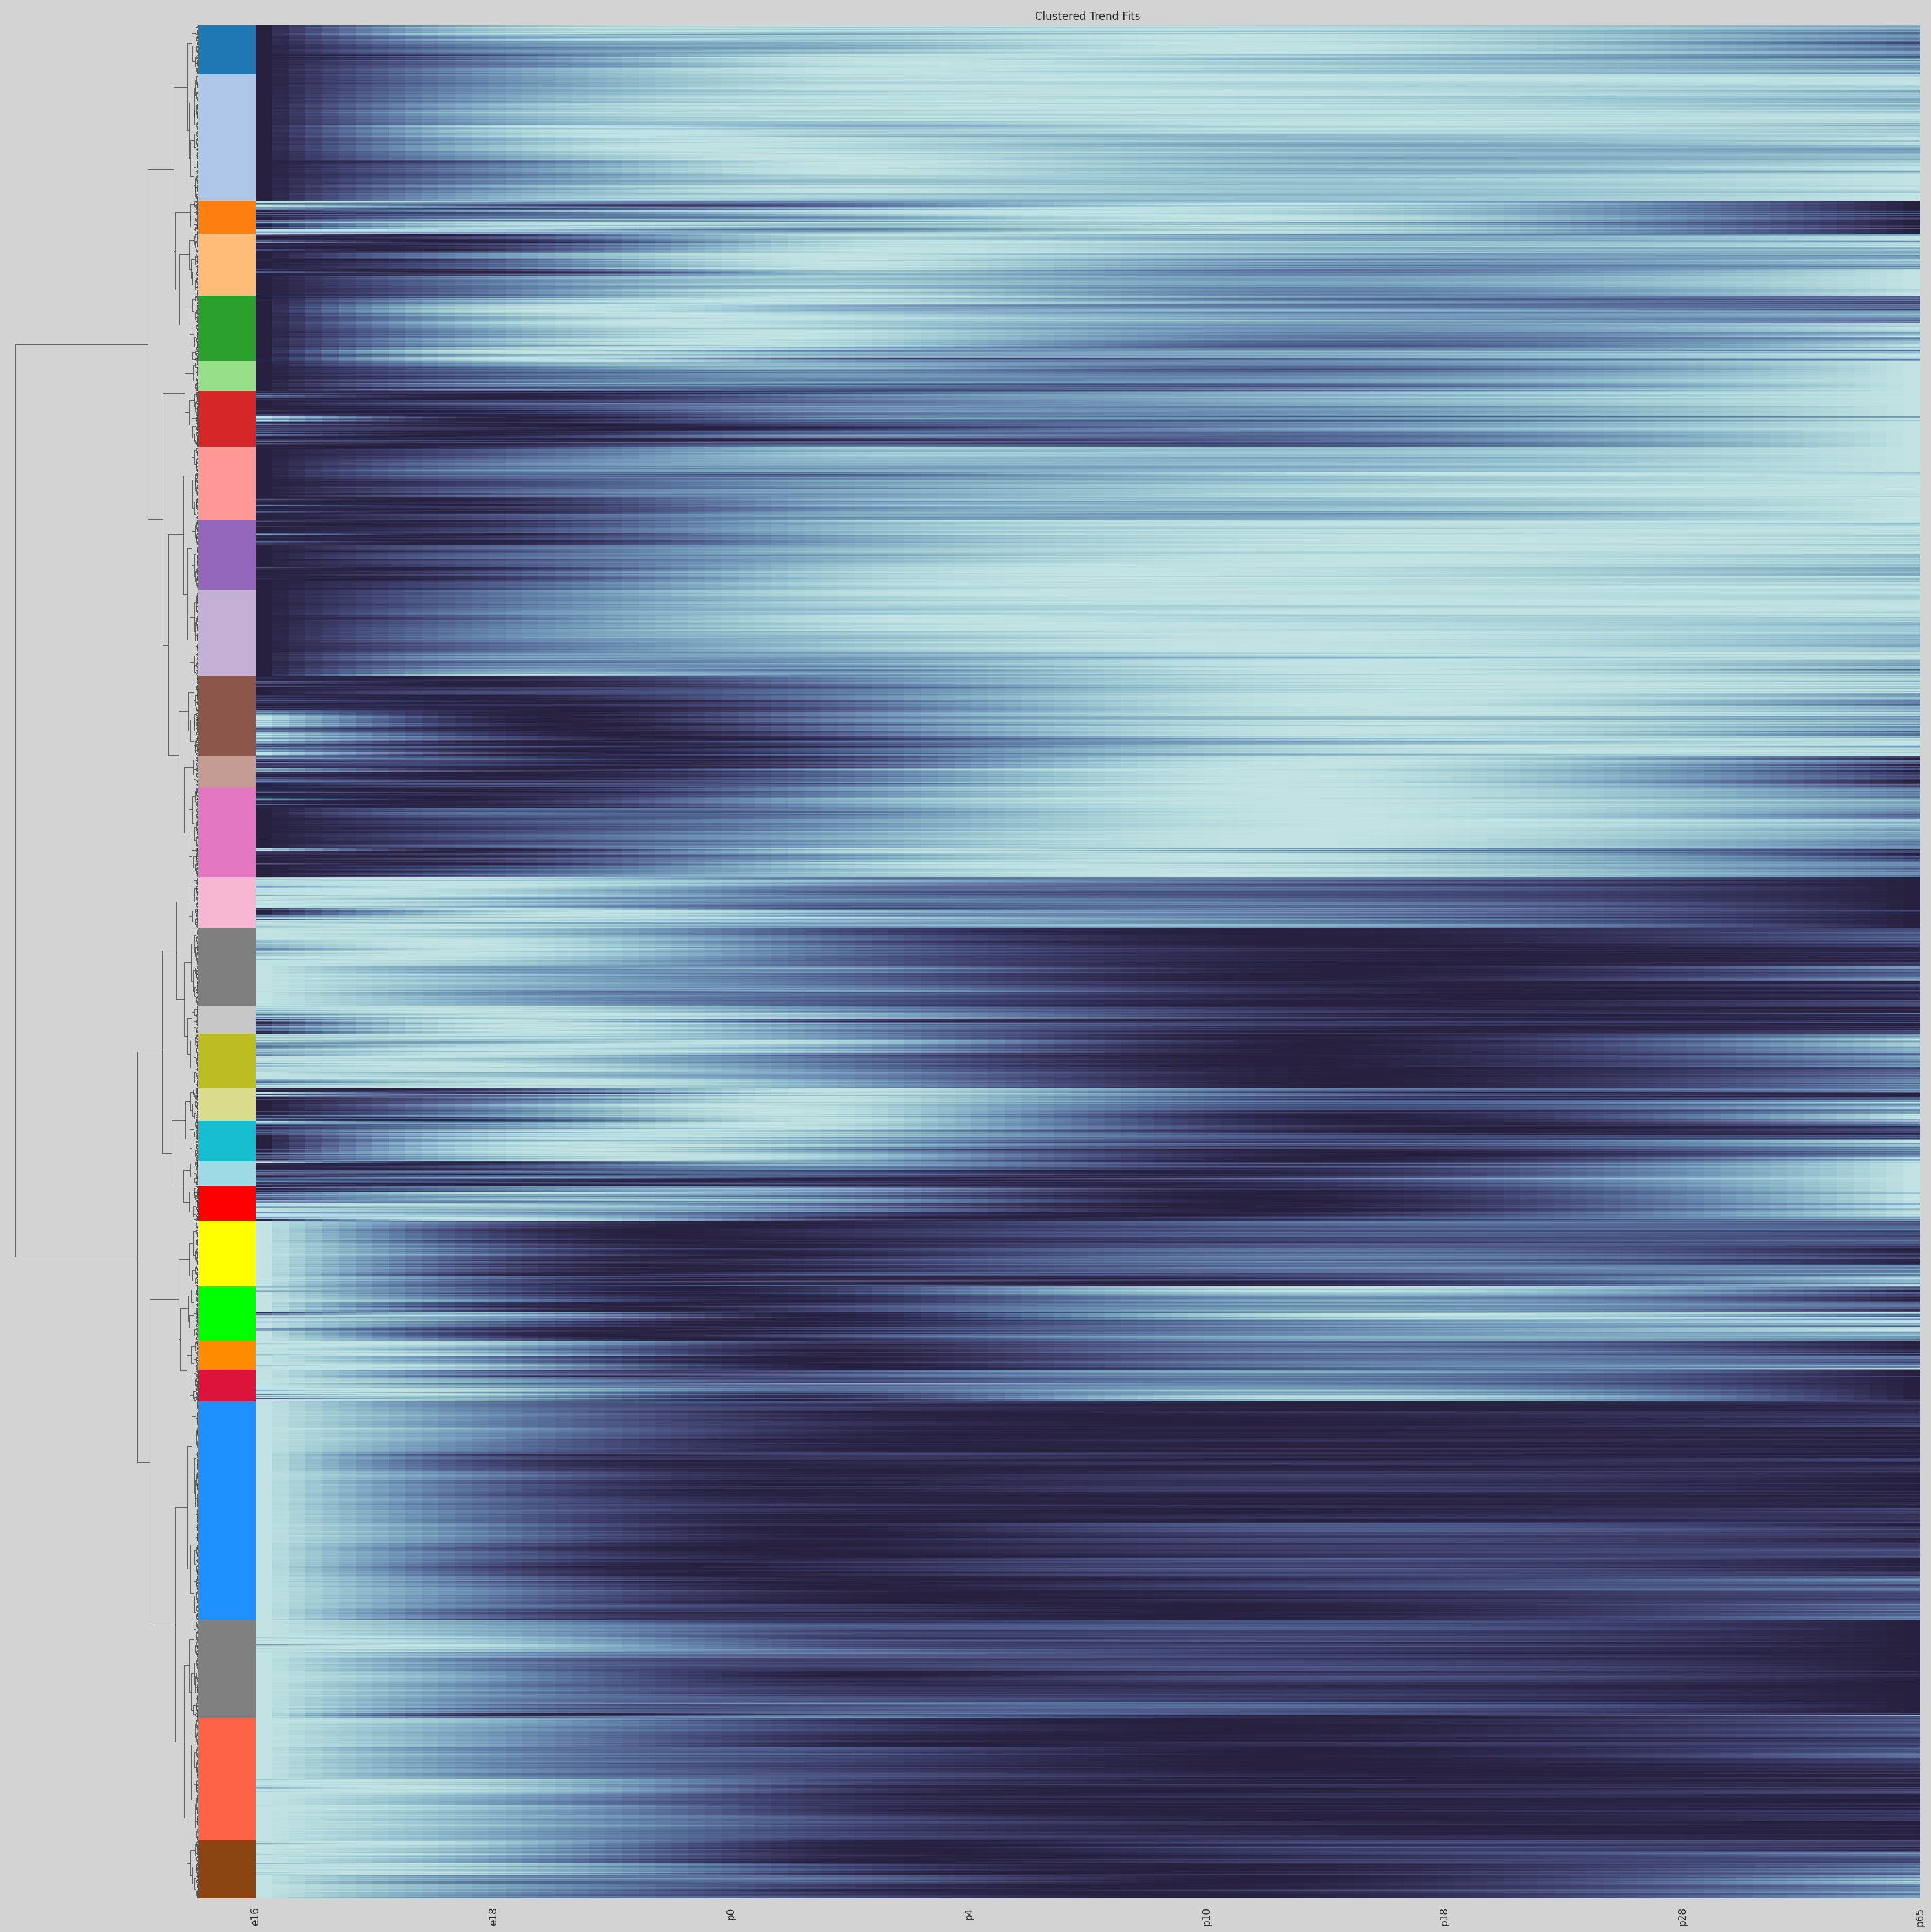

In [17]:
ax = sns.clustermap(all_goods_df.reset_index(drop=True), 
                    row_linkage=dend_link, 
                    row_colors=row_colors, col_cluster=False, 
                    row_cluster=True, 
                    cmap=cmap, 
                    figsize=(30,30), standard_scale=0, 
                    yticklabels=[], 
                    cbar_pos=None, dendrogram_ratio=(0.10,0.01))
num_stages = len(stage_order)
ticks = np.linspace(0, all_goods_df.shape[1], num_stages)
ax.ax_heatmap.set_xticks(ticks)
#ax.ax_heatmap.set_xticklabels(stage_order, rotation=90);
ax.ax_heatmap.set_xticklabels(xlabels, rotation=90)
ax.ax_row_dendrogram.set_visible(True)
plt.setp(ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
ax.ax_heatmap.set_title( "Clustered Trend Fits")

In [38]:
# generalized trends
# down       = ['9','1','2','10','4']
# inter_down = ['12','8']
# inter_up   = ['13','11','5']
# up         = ['7','0','3','6']

### **Figure 2D Gene trend plots**

In [25]:
# genes can be list/array of ints or gene names 
# why scat_df?
def plot_tend_avg( genes, trend_df, scat_df, color='green', alpha=1.0):
    min_max_scaler = preprocessing.MinMaxScaler()
    plt.figure( figsize=(4.625*3,4.625)) #, facecolor='white')
    # plot trend fit
    trends = trend_df.loc[genes,:]
    norm_td = min_max_scaler.fit_transform( trends.T)
    avg_td = np.mean( norm_td, axis=1)
    plt.plot( norm_td, linewidth=1.0, alpha=0.01, color=color)
    plt.plot( avg_td, linewidth=2.5, alpha=alpha, color='black')
    num_stages = len(stage_order)
    ticks = np.linspace(0, n_grid_pts, num_stages)
    plt.xticks( ticks, [""]*len(ticks))
    return

In [21]:
logTMMs

{'i-B1':             i.B1..e16f  i.B1..e16m_apr23  i.B1..e18f  i.B1..e18f_may22  \
 Xkr4          9.875470          9.776237    9.691923          9.430306   
 Gm1992        5.851207          5.232553    6.053854          5.826121   
 Lypla1        4.648846          4.656496    4.351695          4.269053   
 Rgs20         5.023683          5.472803    5.042344          5.925932   
 Oprk1         3.914384          3.921607    4.835120          3.011423   
 ...                ...               ...         ...               ...   
 mt-Nd4l       5.157908          6.542905    6.795302          6.670770   
 mt-Nd4        6.575788          7.983341    8.270962          8.146247   
 mt-Nd5        4.103858          6.613792    6.792165          6.591114   
 mt-Cytb       6.400823          8.149363    7.943531          7.785790   
 AC149090.1    9.426898          9.635268    9.065510          9.608316   
 
             i.B1..e18m  i.B1..e18m_may22  i.B1..p0f  i.B1..p0f2  \
 Xkr4          9.81962

In [27]:
clust_order

NameError: name 'clust_order' is not defined

In [26]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.style.use('seaborn-whitegrid')
# plt.rcParams['axes.facecolor'] = 'white'
# here clusters are clusters on a tree, not brain regions
for clust_itr in clust_order:
    clust_mk = cut_tree==clust_itr
    print( clust_itr, sum(clust_mk))
    clust_genes = all_goods_df.index[clust_mk]
    plot_tend_avg(clust_genes, all_goods_df, logTMMs['i-B1'], alpha=0.9, color=lut[clust_itr])
    plt.title( clust_itr)
    plt.ylim(0.0,1.0)
    plt.xlim(0,n_grid_pts-1)
    plt.savefig(f"data/dev_deg_v9/trend-clust_height-90_{clust_itr}_trend-plots.png", 
                format='png',
                bbox_inches = 'tight')

# defined earlier
# num_stages = len(np.unique(logTMMs['avpe'].columns))
num_stages = len(stage_order)
xticks = np.linspace(0, n_grid_pts-1, num_stages)
plt.xticks(ticks = xticks, labels = xlabels, rotation=90);
# have to the last one to get x-labels
plt.savefig(f"data/dev_deg_v9/trend-clust_height-90_{clust_itr}_trend-plots.png", 
            format='png', 
            bbox_inches='tight')

/tmp/ipykernel_623165/2278640450.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-whitegrid')


NameError: name 'clust_order' is not defined

In [24]:
all_goods_df

0         1         2         3         4   \
cell_type gene                                                           
i-B1      Xkr4        9.767914  9.751990  9.736122  9.720320  9.704596   
          Gm1992      5.630184  5.641261  5.652306  5.663366  5.674488   
          Lypla1      4.288638  4.305782  4.323423  4.341630  4.360474   
          Rgs20       5.145128  5.180054  5.215361  5.251109  5.287360   
          Oprk1       3.752248  3.823546  3.895306  3.967517  4.040169   
...                        ...       ...       ...       ...       ...   
i-V1      mt-Nd3      6.227332  6.417678  6.601117  6.776957  6.944501   
          mt-Nd4      7.767067  7.862882  7.955278  8.043858  8.128220   
          mt-Nd5      6.289676  6.402655  6.513736  6.622487  6.728478   
          mt-Cytb     7.991726  8.053848  8.113576  8.170710  8.225050   
          AC149090.1  9.784026  9.761926  9.739787  9.717722  9.695847   

                            5         6         7         8         9   ...  \
cell_type gene                                                          ...   
i-B1      Xkr4        9.688961  9.673427  9.658004  9.642704  9.627539  ...   
          Gm1992      5.685721  5.697112  5.708709  5.720559  5.732711  ...   
          Lypla1      4.380023  4.400346  4.421512  4.443591  4.466651  ...   
          Rgs20       5.324172  5.361608  5.399728  5.438592  5.478261  ...   
          Oprk1       4.113252  4.186755  4.260667  4.334979  4.409680  ...   
...                        ...       ...       ...       ...       ...  ...   
i-V1      mt-Nd3      7.103055  7.251926  7.390417  7.517836  7.633487  ...   
          mt-Nd4      8.207968  8.282701  8.352021  8.415529  8.472827  ...   
          mt-Nd5      6.831278  6.930454  7.025577  7.116216  7.201939  ...   
          mt-Cytb     8.276397  8.324550  8.369310  8.410477  8.447852  ...   
          AC149090.1  9.674277  9.653125  9.632506  9.612535  9.593327  ...   

                            90        91        92        93        94  \
cell_type gene                                                           
i-B1      Xkr4        9.513503  9.509495  9.505437  9.501334  9.497192   
          Gm1992      6.095930  6.108943  6.122151  6.135534  6.149073   
          Lypla1      5.801185  5.809093  5.816989  5.824874  5.832748   
          Rgs20       6.234677  6.236051  6.237509  6.239041  6.240641   
          Oprk1       5.707762  5.713808  5.719974  5.726248  5.732618   
...                        ...       ...       ...       ...       ...   
i-V1      mt-Nd3      7.640066  7.646962  7.654014  7.661206  7.668523   
          mt-Nd4      8.211285  8.208962  8.206717  8.204542  8.202430   
          mt-Nd5      7.335271  7.339177  7.343269  7.347530  7.351941   
          mt-Cytb     8.457925  8.456895  8.455916  8.454984  8.454093   
          AC149090.1  9.742536  9.721538  9.700269  9.678757  9.657027   

                            95        96        97        98        99  
cell_type gene                                                          
i-B1      Xkr4        9.493014  9.488806  9.484572  9.480318  9.476048  
          Gm1992      6.162750  6.176544  6.190438  6.204412  6.218447  
          Lypla1      5.840614  5.848472  5.856324  5.864170  5.872013  
          Rgs20       6.242299  6.244008  6.245759  6.247545  6.249356  
          Oprk1       5.739073  5.745600  5.752189  5.758826  5.765502  
...                        ...       ...       ...       ...       ...  
i-V1      mt-Nd3      7.675950  7.683472  7.691072  7.698737  7.706451  
          mt-Nd4      8.200373  8.198364  8.196395  8.194457  8.192544  
          mt-Nd5      7.356484  7.361140  7.365892  7.370721  7.375609  
          mt-Cytb     8.453238  8.452414  8.451617  8.450840  8.450080  
          AC149090.1  9.635107  9.613022  9.590800  9.568466  9.546047  

[59116 rows x 100 columns]

In [10]:
good_fits = nmc.load_obj("data/dev_deg_v8/AGE_gam_fits_12_grid100.filtered100.pkl")
mj_order = sorted(good_fits.keys())
mj_order

['e-A1',
 'e-A3',
 'e-A5',
 'e-B1',
 'e-C3',
 'e-C4',
 'e-C5',
 'e-C6',
 'e-C7',
 'e-C8',
 'e-F1',
 'e-H2',
 'e-H5',
 'e-H6',
 'e-H7',
 'e-H8',
 'e-L3',
 'e-L4',
 'e-L6',
 'e-L8',
 'e-M10',
 'e-M5',
 'e-M6',
 'e-M9',
 'e-N1',
 'e-N2',
 'e-N9',
 'e-P1',
 'e-P2',
 'e-P3',
 'e-P4',
 'e-T1',
 'e-T2',
 'e-X1',
 'i-B1',
 'i-B11',
 'i-B12',
 'i-B13',
 'i-B2',
 'i-B3',
 'i-B4',
 'i-B5',
 'i-B6',
 'i-B8',
 'i-C1',
 'i-C2',
 'i-H1',
 'i-H10',
 'i-H11',
 'i-H3',
 'i-H4',
 'i-H5',
 'i-H6',
 'i-H7',
 'i-H8',
 'i-L1',
 'i-L2',
 'i-L3',
 'i-L4',
 'i-L5',
 'i-L6',
 'i-L7',
 'i-M1',
 'i-M10',
 'i-M11',
 'i-M2',
 'i-M5',
 'i-M6',
 'i-M7',
 'i-P1',
 'i-P2',
 'i-P3',
 'i-P4',
 'i-S3',
 'i-S7',
 'i-S8',
 'i-V1',
 'i-V2',
 'i-V3',
 'i-V4',
 'i-V5',
 'i-V7',
 'i-V8',
 'i-V9',
 'i-X1',
 'i-X10',
 'i-X13',
 'i-X14',
 'i-X15',
 'i-X16',
 'i-X17',
 'i-X2',
 'i-X3',
 'i-X4',
 'i-X5',
 'i-X6',
 'i-X7',
 'i-X8',
 'i-X9']

In [11]:
#mj_order = ["i-B1", "i-B2", "i-B3", 
#                 "i-H1", "i-H2", "i-H3",
#                 "i-M1", "i-M2", "i-M3",
#                 "i-M4", "i-M5", "i-M6",
#                 "i-M7", "i-M8", "i-M9", 
#                 "i-P1", 
#                 "i-S1", "i-S2", "i-S3", "i-S4",
#                 "i-S5",
#                 "i-V1"]
# all_cell_types - 99 
mj_order = sorted(good_fits.keys())
#mj_order = ['avpe']
# cell_type vs cluster dataframe
ctype_df = pd.DataFrame( [], index=mj_order, columns=clust_order, dtype=int)
ctype_df[:] = 0
# loop through each cluster   
for clust_itr in clust_order:
    clust_mk = cut_tree==clust_itr
    # all genes in a cluster regardless of the cell type
    clust_genes = all_goods_df.index[clust_mk]
    clust_df = all_goods_df.loc[clust_genes,:]
    # loop through each cell_type
    for cell_itr in all_goods_df.index.unique(level='cell_type'):
        # get genes in each combo
        if(cell_itr not in clust_df.index.unique( level='cell_type')):
            continue
        else:
            cell_df = clust_df.loc[cell_itr]
            # cell_df is a matrix gene x expression approximation at 100 time points
            # ctype_df holds how many DEG are for cluster x cell_type combination
            ctype_df.loc[cell_itr,clust_itr] = cell_df.shape[0]
        # get counts for each cell_type and cluster
        print( clust_itr, cell_itr)

NameError: name 'clust_order' is not defined

In [49]:
# total DEG per cell_type
layer_tots = ctype_df.sum(1).values
# pct of DEG in a cell type for each cluster
ctype_df = ctype_df.divide(layer_tots, axis='rows')*100

In [51]:
layer_tots

array([5253., 3881., 4072., 4218.,  582., 3359., 3233., 4307., 1330.,
        754., 4644., 4271., 3077.,    0.,  432., 8320.,  982.,    0.,
       1923.,  524.,  868., 3086.])

In [27]:
# po = [color_dict[ii] for ii in mj_order]
# for each cluster
# plot a barplot of cell types
for itr in ctype_df.columns.values:
    fig, ax = plt.subplots(1, 1, figsize=(3,4.625))
    # ADDED: Remove labels
    sns.barplot(y = ctype_df.index, 
                x=ctype_df.loc[:,itr], 
                hue_order=mj_order, 
                order=mj_order, 
                palette=tab20, 
                ax = ax);
    ax.set_ylabel('')    
    ax.set_xlabel('')
    ax.set_yticklabels('')
    plt.title( itr);
    plt.xlim(0,40)
    plt.savefig( f"data/dev_deg_v9//mj-clusts-gene-clust_height-90_{itr}_bar-plots.png", 
                format='png', bbox_inches='tight')